In [12]:
%load_ext autoreload
%autoreload 2
import sys
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D
sys.path.insert(0, "../../scripts/")
# from scriptsload_encoder_decoder import build_encoder_decoder_from_vgg
# from data_generator import DataGenerator
# from losses import overall_loss_wrapper
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import multi_gpu_model
from keras.models import load_model
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Activation
from keras.optimizers import Adam
import numpy as np
# from unpooling import Unpooling
from matplotlib.pyplot import imshow, figure
# from model import build_encoder_decoder, build_refinement
import cv2 as cv
import math
import tensorflow as tf
from scipy import misc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from keras import backend as K

In [13]:
vgg = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(448, 320, 3))

In [20]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 300, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 100, 128)      0         
__________

In [5]:
def pad_if_needed(target, rest):
    target_w, target_h = K.shape(target)[1], K.shape(target)[2]
    padded = []
    for tensor in rest:
        tensor_w, tensor_h = K.shape(tensor)[1], K.shape(tensor)[2]
        delta_w = target_w - tensor_w
        delta_h = target_h - tensor_h
        x = ZeroPadding2D(padding=((delta_h, 0), (delta_w, 0)))(tensor)
        padded.append(x)
    return tuple(padded)

In [4]:
def deconv2d(x, kernel, strides, name, output_shape, activation=None):
    kernel_shape = [kernel, kernel, 1, 1]
    strides = [1, strides, strides, 1]
    kernel = tf.get_variable('weight_{}'.format(name), shape=kernel_shape,
                             initializer=tf.random_normal_initializer(mean=0, stddev=1))
    deconv = tf.nn.conv2d_transpose(x, kernel, strides=strides, output_shape=output_shape, padding='SAME',
                                    name=name)
    if activation is not None:
        return Activation(activation)(deconv)
    return deconv #K.conv2d_transpose(x, kernel, output_shape, strides=(1, 1), padding='SAME', name=name)


In [7]:
K.shape(vgg.input)

<tf.Tensor 'Shape_13:0' shape=(4,) dtype=int32>

In [14]:
output_shape = tf.stack([tf.shape(vgg.input)[0], tf.shape(vgg.input)[1], tf.shape(vgg.input)[2], 1])

filters_init = 256
#maybe reduce here?
#block6
pool5 = vgg.get_layer("block5_pool")

conv1_side_pool5 = Conv2D(filters=filters_init, kernel_size=(7, 7), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv1_side_pool5")(pool5.output)
conv2_side_pool5 = Conv2D(filters=filters_init, kernel_size=(7, 7), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv2_side_pool5")(conv1_side_pool5)
conv3_side_pool5 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv3_side_pool5")(conv2_side_pool5)
score_side_pool5_up = Conv2DTranspose(filters=1, kernel_size=64, strides=32, name="upsampling_side_pool5", padding="same")(conv3_side_pool5)
# score_side_pool5_up = deconv2d(conv3_side_pool5, 64, 32 ,"upsampling_side_pool5", output_shape)

#block5
block5_conv3 = vgg.get_layer("block5_conv3")

conv1_side5 = Conv2D(filters=filters_init, kernel_size=(5, 5), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv1_side5")(block5_conv3.output)
conv2_side5 = Conv2D(filters=filters_init, kernel_size=(5, 5), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv2_side5")(conv1_side5)
conv3_side5 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv3_side5")(conv2_side5)
score_side5_up = Conv2DTranspose(filters=1, kernel_size=32, strides=16, name="upsampling_side5", padding="same")(conv3_side5)
# score_side5_up = deconv2d(conv3_side5, 32, 16, "upsampling_side5", output_shape)

#block4
block4_conv3 = vgg.get_layer("block4_conv3")

conv1_side4 = Conv2D(filters=filters_init//2, kernel_size=(5, 5), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv1_side4")(block4_conv3.output)
conv2_side4 = Conv2D(filters=filters_init//2, kernel_size=(5, 5), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv2_side4")(conv1_side4)
conv3_side4 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv3_side4")(conv2_side4)
score_side_pool5_up_4 = Conv2DTranspose(filters=1, kernel_size=8, strides=4, name="upsampling_c3_sp5_4", padding="same")(conv3_side_pool5)
# score_side_pool5_up_4 = deconv2d(conv3_side_pool5, 8, 4, "upsampling_c3_sp5_4", K.shape(conv3_side4))

score_side5_up_4 = Conv2DTranspose(filters=1, kernel_size=4, strides=2, name="upsampling_c3_s5_4", padding="same")(conv3_side5)
# score_side5_up_4 = deconv2d(conv3_side5, 4, 2, "upsampling_c3_s5_4", K.shape(conv3_side4))
print(K.int_shape(conv3_side4))

concat_side4 = Concatenate(name="concat_s4")([conv3_side4, score_side_pool5_up_4, score_side5_up_4])
conv4_side4 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv4_side4")(concat_side4)
score_side4_up = Conv2DTranspose(filters=1, kernel_size=16, strides=8, name="upsampling_concat4", padding="same")(conv4_side4)
# score_side4_up = deconv2d(conv4_side4, 16, 8, "upsampling_concat4", output_shape)

#block3
block3_conv3 = vgg.get_layer("block3_conv3")

conv1_side3 = Conv2D(filters=filters_init//2, kernel_size=(5, 5), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv1_side3")(block3_conv3.output)
conv2_side3 = Conv2D(filters=filters_init//2, kernel_size=(5, 5), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv2_side3")(conv1_side3)
conv3_side3 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv3_side3")(conv2_side3)

score_side_pool5_up_3 = Conv2DTranspose(filters=1, kernel_size=16, strides=8, name="upsampling_c3_sp5_3", padding="same")(conv3_side_pool5)
# score_side_pool5_up_3 = deconv2d(conv3_side_pool5, 16, 8, "upsampling_c3_sp5_3", K.shape(conv3_side3))

score_side5_up_3 = Conv2DTranspose(filters=1, kernel_size=8, strides=4, name="upsampling_c3_s5_3", padding="same")(conv3_side5)
# score_side5_up_3 = deconv2d(conv3_side5, 8, 4, "upsampling_c3_s5_3", K.shape(conv3_side3))

concat_side3 = Concatenate(name="concat_side3")([conv3_side3, score_side_pool5_up_3, score_side5_up_3])
conv4_side3 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv4_side3")(concat_side3)
score_side3_up = Conv2DTranspose(filters=1, kernel_size=8, strides=4, name="upsampling_concat3", padding="same")(conv4_side3)
# score_side3_up = deconv2d(conv4_side3, 8, 4, "upsampling_concat3", output_shape)

#block2
block2_conv2 = vgg.get_layer("block2_conv2")
conv1_side2 = Conv2D(filters=filters_init//4, kernel_size=(3, 3), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv1_side2")(block2_conv2.output)
conv2_side2 = Conv2D(filters=filters_init//4, kernel_size=(3, 3), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv2_side2")(conv1_side2)
conv3_side2 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv3_side2")(conv2_side2)

score_side_pool5_up_2 = Conv2DTranspose(filters=1, kernel_size=32, strides=16, name="upsampling_c3_sp5_2", padding="same")(conv3_side_pool5)
# score_side_pool5_up_2 = deconv2d(conv3_side_pool5, 32, 16, "upsampling_c3_sp5_2", K.shape(conv3_side2))

score_side5_up_2 = Conv2DTranspose(filters=1, kernel_size=16, strides=8, name="upsampling_c3_s5_2", padding="same")(conv3_side5)
# score_side5_up_2 = deconv2d(conv3_side5, 16, 8, "upsampling_c3_s5_2", K.shape(conv3_side2))

score_side4_up_2 = Conv2DTranspose(filters=1, kernel_size=8, strides=4, name="upsampling_c3_s4_2", padding="same")(conv3_side4)
#  score_side4_up_2 = deconv2d(conv3_side4, 8, 4, "upsampling_c3_s4_2", K.shape(conv3_side2))

score_side3_up_2 = Conv2DTranspose(filters=1, kernel_size=4, strides=2, name="upsampling_c3_s3_2", padding="same")(conv3_side3)
# score_side3_up_2 = deconv2d(conv3_side3, 4, 2, "upsampling_c3_s3_2", K.shape(conv3_side2))

concat_side2 = Concatenate(name="concat_side2")([conv3_side2, score_side_pool5_up_2, score_side5_up_2, score_side4_up_2, score_side3_up_2])

conv4_side2 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv4_side2")(concat_side2)
score_side2_up = Conv2DTranspose(filters=1, kernel_size=4, strides=2, name="upsampling_concat2", padding="same")(conv4_side2)
# score_side2_up = deconv2d(conv4_side2, 4, 2, "upsampling_concat2", output_shape)

#block1
block1_conv2 = vgg.get_layer("block1_conv2")
conv1_side1 = Conv2D(filters=filters_init//4, kernel_size=(3, 3), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv1_side1")(block1_conv2.output)
conv2_side1 = Conv2D(filters=filters_init//4, kernel_size=(3, 3), strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv2_side1")(conv1_side1)
conv3_side1 = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv3_side1")(conv2_side1)

score_side_pool5_up_1 = Conv2DTranspose(filters=1, kernel_size=64, strides=32, name="upsampling_c3_sp5_1", padding="same")(conv3_side_pool5)
# score_side_pool5_up_1 = deconv2d(conv3_side_pool5, 64, 32, "upsampling_c3_sp5_1", K.shape(conv3_side1))

score_side5_up_1 = Conv2DTranspose(filters=1, kernel_size=32, strides=16, name="upsampling_c3_s5_1", padding="same")(conv3_side5)
# score_side5_up_1 = deconv2d(conv3_side5, 32, 16, "upsampling_c3_s5_1", K.shape(conv3_side1))

score_side4_up_1 = Conv2DTranspose(filters=1, kernel_size=16, strides=8, name="upsampling_c3_s4_1", padding="same")(conv3_side4)
# score_side4_up_1 = deconv2d(conv3_side4, 16, 8, "upsampling_c3_s4_1", K.shape(conv3_side1))

score_side3_up_1 = Conv2DTranspose(filters=1, kernel_size=8, strides=4, name="upsampling_c3_s3_1", padding="same")(conv3_side3)
# score_side3_up_1 = deconv2d(conv3_side3, 8, 4, "upsampling_c3_s3_1", K.shape(conv3_side1))

concat_side1 = Concatenate(name="concat_side1")([conv3_side1, score_side_pool5_up_1, score_side5_up_1, score_side4_up_1, score_side3_up_1])
score_side1_up = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv4_side1")(concat_side1)

#fusing

concat_fusion = Concatenate(name="concat_fusion")([score_side1_up, score_side2_up, score_side3_up, score_side4_up, score_side5_up, score_side_pool5_up])
# concat_fusion = tf.concat([score_side1_up, score_side2_up, score_side3_up, score_side4_up, score_side5_up, score_side_pool5_up], axis=-1, name="concat_fusion")
score_fusion = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding="valid", kernel_initializer="he_normal", activation=None, name="conv_fuse")(concat_fusion)


(None, 56, 40, 1)


In [9]:
tf.get_variable_scope().reuse_variables()

In [15]:
model = Model(inputs=vgg.input, outputs=[score_side1_up, score_side2_up, score_side3_up, score_side4_up, score_side5_up, score_side_pool5_up, score_fusion])

In [16]:
losses = {
    "conv4_side1": "binary_crossentropy",
    "upsampling_concat2": "binary_crossentropy",
    "upsampling_concat3": "binary_crossentropy",
    "upsampling_concat4": "binary_crossentropy",
    "upsampling_side5": "binary_crossentropy",
    "upsampling_side_pool5": "binary_crossentropy",
    "conv_fuse": "binary_crossentropy"
}

loss_weights = {
    "conv4_side1": 1,
    "upsampling_concat2": 1,
    "upsampling_concat3": 1,
    "upsampling_concat4": 1,
    "upsampling_side5": 1,
    "upsampling_side_pool5": 1.0,
    "conv_fuse": 1
}

In [9]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights)

In [17]:
img = cv.imread("D:\\saliency dataset\\ecssd\\images\\0001.jpg")
alpha = cv.imread("D:\\saliency dataset\\ecssd\\ground_truth_mask\\0001.jpg")

In [18]:
model.predict(cv.resize(img, (448, 320)).reshape(1, 448, 320, 3))

[array([[[[  58.028465 ],
          [ 204.71382  ],
          [ 206.65106  ],
          ...,
          [-113.710724 ],
          [-193.81927  ],
          [-208.71951  ]],
 
         [[   3.2643242],
          [  84.151474 ],
          [  71.22215  ],
          ...,
          [ -89.92949  ],
          [ 112.15198  ],
          [-110.76356  ]],
 
         [[-413.92596  ],
          [ 149.18294  ],
          [ 121.18053  ],
          ...,
          [-174.77713  ],
          [-248.69264  ],
          [-425.91666  ]],
 
         ...,
 
         [[ -75.3498   ],
          [ -81.38957  ],
          [-113.672066 ],
          ...,
          [-180.74979  ],
          [ -29.568298 ],
          [-198.38104  ]],
 
         [[  22.41048  ],
          [ 126.39203  ],
          [  93.544235 ],
          ...,
          [-204.58643  ],
          [-120.91881  ],
          [-155.79468  ]],
 
         [[ -73.40959  ],
          [-174.6529   ],
          [-219.22844  ],
          ...,
          [-172.6671 

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 160, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [13]:
from keras.utils import plot_model
plot_model(model, to_file="hed_short_conn.png")

In [20]:
!pwd

/c/Workspace/ThesisImageMatting/notebooks/saliency


In [35]:
sys.path.insert(0, "../../")

from scripts.saliency.saliency_data_generator import get_data_generators

In [36]:
train_gen, test_gen = get_data_generators()

Found 13902 images belonging to 1 classes.
Found 13902 images belonging to 1 classes.
Found 1545 images belonging to 1 classes.
Found 1545 images belonging to 1 classes.


In [37]:
x=next(train_gen)

In [30]:
from matplotlib.pyplot import imshow

In [33]:
x[0][0]

array([[[34.       , 36.       , 25.       ],
        [34.       , 36.       , 25.       ],
        [34.       , 36.       , 25.       ],
        ...,
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ]],

       [[34.       , 36.       , 25.       ],
        [34.       , 36.       , 25.       ],
        [34.       , 36.       , 25.       ],
        ...,
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ]],

       [[34.       , 36.       , 25.       ],
        [34.       , 36.       , 25.       ],
        [34.       , 36.       , 25.       ],
        ...,
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ]],

       ...,

       [[ 9.       , 10.       ,  5.       ],
        [ 9.       , 10.       ,  5.       ],
        [ 9.       , 1

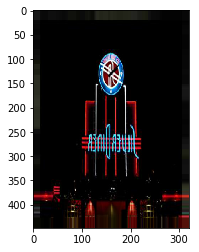

In [38]:
imshow(x[0][0].astype(np.uint8))

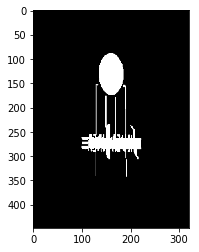

In [39]:
imshow(x[1][0].astype(np.uint8))